# Text Coherence

## sentence-transformers (SBERT)
[issue](https://github.com/huggingface/transformers/issues/37326)


When computing coherence, I currently return the `mean` of the similarities.

***If problems, run with with Python version < 3.11***

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import nltk
import json
import re
from html import unescape
import pandas as pd

color_palette = ['#5565cf', '#b14ecf', '#cf4773', '#cf913f', '#87cf38', '#30cf6b', '#29a1cf', '#2138cf']

file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

In [ ]:
nltk.download('punkt')

# Load the SBERT model once (can reuse for all stories)
sbert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Function to calculate coherence score
def compute_coherence_score(text, model):
    # Sentence tokenization
    sentences = nltk.sent_tokenize(text)
    
    # Can't compute coherence with fewer than 2 sentences
    if len(sentences) < 2:
        return 0
    
    # Compute sentence embeddings
    embeddings = model.encode(sentences, normalize_embeddings=True)
    
    # Cosine similarity between consecutive sentence embeddings
    similarities = []
    for i in range(len(embeddings) - 1):
        sim = cosine_similarity(
            embeddings[i].reshape(1, -1),
            embeddings[i + 1].reshape(1, -1)
        )[0][0]
        similarities.append(sim)
    
    # Average similarity as the coherence score
    return np.mean(similarities)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\giuli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Iterate over data stories

In [ ]:
def clean_text(html_text):
    # Unescape HTML entities
    text = unescape(html_text)
    # Remove HTML tags
    text = re.sub(r"<[^>]+>", "", text)
    # Replace non-breaking space and other escaped characters
    text = text.replace("\xa0", " ").strip()
    return text

coherence_results = []

for story_id, story in data.items():
    raw_texts = story.get("texts", [])
    cleaned_texts = [clean_text(t) for t in raw_texts]
    full_text = " ".join(cleaned_texts)
    
    # Only compute if text is not empty
    if full_text.strip():
        score = compute_coherence_score(full_text, sbert_model)
    else:
        score = 0
    
    coherence_results.append({
        "story_id": story_id,
        "coherence_score": score
    })

# Create a new DataFrame
df_coherence = pd.DataFrame(coherence_results)

# Save to file if needed
df_coherence.to_csv("outputs/coherence_scores.csv")

print(df_coherence)

    story_id  coherence_score
0   D-hp3wDV         0.474177
1   y4Srva15         0.607225
2   7qpfziir         0.400856
3   Nokx0yU6         0.448644
4   gz_gxhYn         0.485120
5   U2OtB3XT         0.477771
6   v4h_GSI0         0.494491
7   1ptR3pru         0.371101
8   JQpdcw-d         0.324628
9   B9SLlUry         0.500776
10  r7i-PG2n         0.424629
11  AUmcnOzL         0.499262
12  tyK82z37         0.414790
13  IRRbkmZk         0.377350
14  Vy4_Rxzv         0.458122
15  M9EZmoBI         0.412262
16  uhDaBOl1         0.461460
17  SXefpzf4         0.000000
18  EzsIH_Et         0.000000
19  16FP4tfG         0.577609
20  sUMoEZI5         0.413483
21  _HnVHPjm         0.232419
22  4D206Lam         0.390927
23  j3ZikN40         0.548674
24  BOGODrvZ         0.471665
25  abkhtH-r         0.365663
26  Huo1mZpJ         0.441470
27  JYOzBt8Y         0.734745
28  buiNjeJj         0.342267
29  PziKYGG_         0.463232
30  wa1_2kB_         0.548413
31  lkuzAhad         0.390729
32  jamFJt

## Correlation Coherence X SPARQL Profiency

In [2]:
import pandas as pd

color_palette = ['#5565cf', '#b14ecf', '#cf4773', '#cf913f', '#87cf38', '#30cf6b', '#29a1cf', '#2138cf']

df_coherence = pd.read_csv('outputs/coherence_scores.csv', index_col=0)
df_sparql = pd.read_csv('outputs/sparql_proficiency_final.csv', index_col=0)
df_alternation = pd.read_csv('outputs/alternation_scores.csv', index_col=0)

df_temp = pd.merge(df_coherence[['story_id', 'coherence_score']],
                       df_sparql[['story_id', 'sparql_proficiency']],
                       on='story_id', how='inner')

df_combined = pd.merge(
    df_temp,
    df_alternation[['story_id', 'alternation_score']],
    on='story_id',
    how='inner'
)

story_no_text = ['SXefpzf4', 'EzsIH_Et', '6yGct8pP']

df_filtered = df_combined[~df_combined['story_id'].isin(story_no_text)]


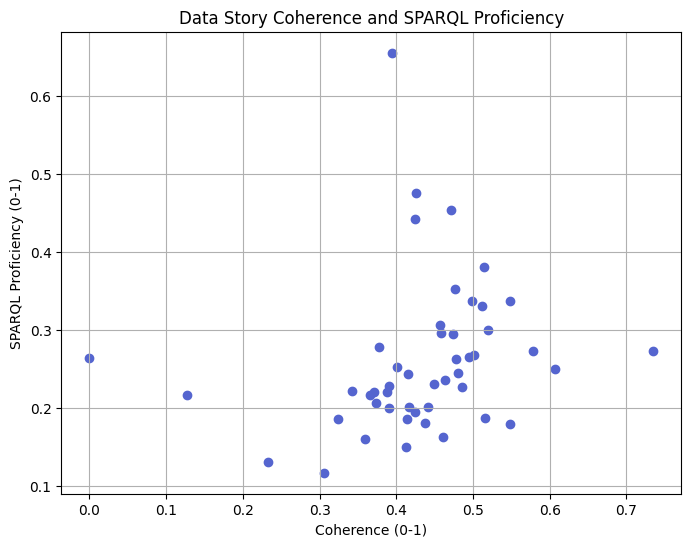

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['coherence_score'], df_filtered['sparql_proficiency'], color=color_palette[0])
plt.xlabel("Coherence (0-1)")
plt.ylabel("SPARQL Proficiency (0-1)")
plt.title("Data Story Coherence and SPARQL Proficiency")
plt.grid(True)
plt.show()

In [3]:
from scipy.stats import pearsonr, spearmanr

# Pearson (with p-values)
pearson_corr, pearson_p = pearsonr(df_filtered['coherence_score'], df_filtered['sparql_proficiency'])

# Spearman (with p-values)
spearman_corr, spearman_p = spearmanr(df_filtered['coherence_score'], df_filtered['sparql_proficiency'])

# Print all results
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Pearson correlation: 0.200 (p-value: 0.172)
Spearman correlation: 0.438 (p-value: 0.002)


Rank-based trend (Spearman) is moderately strong and statistically significant.
Stories that are judged more coherent tend to come from users with higher SPARQL proficiency.

Even if the exact scores of coherence aren't tightly linearly related to SPARQL proficiency, better ranked coherence tends to associate with better SPARQL skills.

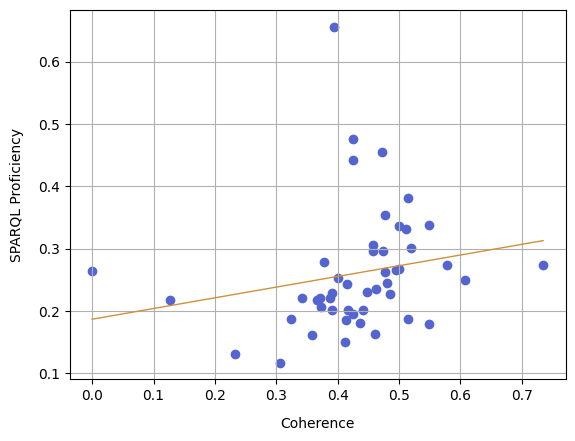

In [ ]:
import numpy as np
 
x = np.array(df_filtered['coherence_score'])
y = np.array(df_filtered['sparql_proficiency'])
 
# Compute best-fit line (linear regression)
m, b = np.polyfit(x, y, 1)  # 1st-degree polynomial (y = mx + b)
 
# Create scatter plot
plt.scatter(x, y, color=color_palette[0], label="Data points")
 
# Plot best-fit line
x_sorted = np.sort(x)
plt.plot(x_sorted, m*x_sorted + b, color=color_palette[3], linewidth=1, label="Best-fit line")
 
# Labels and title
plt.xlabel("Coherence", labelpad=10)
plt.ylabel("SPARQL Proficiency", labelpad=10)
# plt.title("Data Story Coherence and SPARQL Proficiency")
plt.grid(True)
# plt.savefig("outputs/img/15.jpg", dpi=300, bbox_inches="tight", format="jpg")

# Save as EPS (vector format, resolution-independent)
# plt.savefig("outputs/img/15.eps", format="eps", bbox_inches="tight")
plt.show()

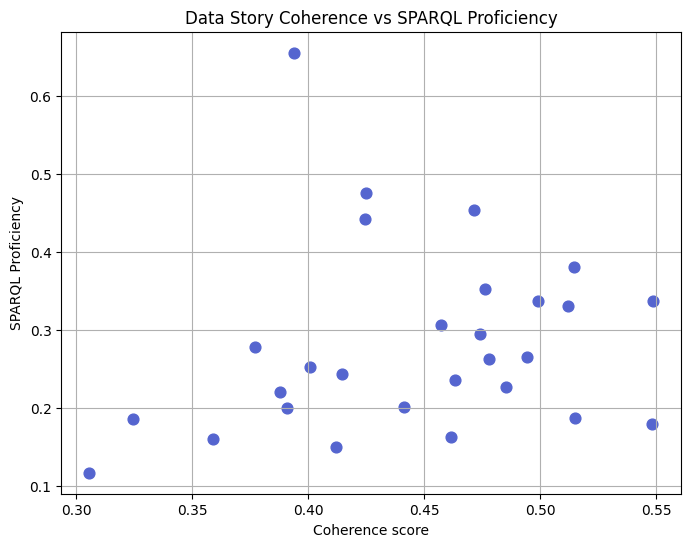

In [5]:
# Create a boolean mask: True if alternation_score > 0.7, else False
high_alternation = df_filtered['alternation_score'] >= 0.7

plt.figure(figsize=(8, 6))

# Plot points with high alternation score
plt.scatter(
    df_filtered.loc[high_alternation, 'coherence_score'],  # x-values
    df_filtered.loc[high_alternation, 'sparql_proficiency'],      # y-values
    label='High alternation (>=0.7)', 
    marker='o',  # shape of points
    s=60,  # size of points
    color=color_palette[0]
)


plt.xlabel('Coherence score')
plt.ylabel('SPARQL Proficiency')
plt.title('Data Story Coherence vs SPARQL Proficiency')
plt.grid(True)
plt.show()


In [7]:
from scipy.stats import pearsonr, spearmanr

df_high = df_filtered[high_alternation]

# Now extract the correct columns
x = df_high['coherence_score']
y = df_high['sparql_proficiency']

# Pearson correlation
pearson_corr, pearson_p = pearsonr(x, y)

# Spearman correlation
spearman_corr, spearman_p = spearmanr(x, y)

# Print results
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")


Pearson correlation: 0.180 (p-value: 0.358)
Spearman correlation: 0.314 (p-value: 0.104)


In the high alternation stories, coherence score and SPARQL proficiency show a small positive trend:
➔ More proficient users might tend to create slightly more coherent stories.
But the trend is weak and not statistically confirmed in this filtered subset.

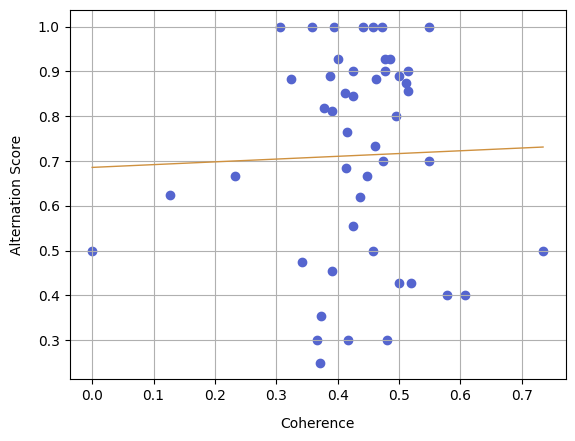

In [ ]:
x = np.array(df_filtered['coherence_score'])
y = np.array(df_filtered['alternation_score'])
 
# Compute best-fit line (linear regression)
m, b = np.polyfit(x, y, 1)  # 1st-degree polynomial (y = mx + b)
 
# Create scatter plot
plt.scatter(x, y, color=color_palette[0], label="Data points")
 
# Plot best-fit line
x_sorted = np.sort(x)
plt.plot(x_sorted, m*x_sorted + b, color=color_palette[3], linewidth=1, label="Best-fit line")
 
# Labels and title
plt.xlabel("Coherence", labelpad=10)
plt.ylabel("Alternation Score", labelpad=10)
plt.grid(True)
# Save as JPG with 300 dpi and EPS (vector format, resolution-independent)
# plt.savefig("outputs/img/21.jpg", dpi=300, bbox_inches="tight", format="jpg")
# plt.savefig("outputs/img/21.eps", format="eps", bbox_inches="tight")
plt.show()

In [6]:
# Pearson correlation
pearson_corr, pearson_p = pearsonr(x, y)

# Spearman correlation
spearman_corr, spearman_p = spearmanr(x, y)

# Print results
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Pearson correlation: 0.030 (p-value: 0.839)
Spearman correlation: 0.032 (p-value: 0.830)
